# StackOverflow NLP Analysis  

# Imports

In [187]:
import os
import re
import string

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np

import pandas as pd
import pymongo

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [153]:
# Global Variables
COLLECTIONS = [
    "ai_questions",
    "ml_questions",
    "nlp_questions",
]
MAX_NGRAM_LENGTH = 1
VECTOR_LENGTH = 2000
SET_RANDOM = 42 

# Data Ingest

In [34]:
# Retrieve questions from MongoDB
def get_question_txt(collection: str) -> list:
    client = pymongo.MongoClient(host="localhost", port=27017)
    db = client["stackoverflow"]
    ai = pymongo.collection.Collection(database=db, name=collection)
    cursor = ai.find({})
    return [(collection, i["url"], i["title"], i["question"]) for i in cursor]


# Write corpus to pandas df
def convert_corpus(collection: list) -> dict:
    corp = {
        "so_tag": [],
        "title": [],
        "url": [],
        "question": [],
    }
    
    for c in collection:
        docs = get_question_txt(c)
        for q in docs:
            corp["so_tag"].append(q[0])
            corp["url"].append(q[1])
            corp["title"].append(q[2])
            corp["question"].append(q[3])
            
    return pd.DataFrame(corp)

In [96]:
cdf = convert_corpus(collections)
cdf.shape

(1494, 4)

Some questions have multiple tags which resulted in duplicate questions in the corpus. I've dropped these questions (roughly 46 questions equalling 92 rows). This ensures that I have 3 independent samples based on the question tag on StackOverflow.

In [98]:
cdf.drop_duplicates(subset="url", keep=False, inplace=True)
cdf.reset_index(inplace=True, drop=True)
cdf.head()

,so_tag,title,url,question
0,ai_questions,What is the optimal algorithm for the game 2048?,/questions/22342854/what-is-the-optimal-algori...,I have recently stumbled upon the game 2048. Y...
1,ai_questions,Pacman: how do the eyes find their way back to...,/questions/3148435/pacman-how-do-the-eyes-find...,I found a lot of references to the AI of the g...
2,ai_questions,What is the best Battleship AI?,/questions/1631414/what-is-the-best-battleship-ai,"Battleship! Back in 2003 (when I was 17), I co..."
3,ai_questions,source of historical stock data [closed],/questions/754593/source-of-historical-stock-data,I'm trying to make a stock market simulator (p...
4,ai_questions,What are good examples of genetic algorithms/g...,/questions/1538235/what-are-good-examples-of-g...,Genetic algorithms (GA) and genetic programmin...


# Tokenization

In [100]:
# Regex for removing punctuation
re_punc = re.compile("[%s]" % re.escape(string.punctuation))


# Tokenize text and join back as one string
def tokenize_txt(txt: str):
    tok = word_tokenize(txt)
    tok = [w.lower() for w in tok]
    tok = [re_punc.sub("", w) for w in tok]
    tok = [word for word in tok if word.isalpha()]
    stop_words = set(stopwords.words("english"))
    tok = [w for w in tok if w not in stop_words]
    return " ".join(tok)

In [101]:
# Testing the tokenize function
tokenize_txt(cdf["question"][0])

'recently stumbled upon game merge similar tiles moving four directions make bigger tiles move new tile appears random empty position value either game terminates boxes filled moves merge tiles create tile value one need follow welldefined strategy reach goal thought writing program current algorithm point try merge tiles values try tiles minimum possible try way tiles automatically getting merged strategy seems good actually use algorithm get around points game terminates maximum points afaik slightly points way larger current score better algorithm'

In [111]:
# Tokenize questions
cdf["cleaned_question"] = cdf["question"].apply(tokenize_txt)

# Create document id based on unique numeric value from URL field
cdf["doc_id"] = cdf.apply(lambda r: r["url"].split("/")[2], axis=1)
cdf.head()

,so_tag,title,url,question,cleaned_question,doc_id
0,ai_questions,What is the optimal algorithm for the game 2048?,/questions/22342854/what-is-the-optimal-algori...,I have recently stumbled upon the game 2048. Y...,recently stumbled upon game merge similar tile...,22342854
1,ai_questions,Pacman: how do the eyes find their way back to...,/questions/3148435/pacman-how-do-the-eyes-find...,I found a lot of references to the AI of the g...,found lot references ai ghosts pacman none men...,3148435
2,ai_questions,What is the best Battleship AI?,/questions/1631414/what-is-the-best-battleship-ai,"Battleship! Back in 2003 (when I was 17), I co...",battleship back competed battleship ai coding ...,1631414
3,ai_questions,source of historical stock data [closed],/questions/754593/source-of-historical-stock-data,I'm trying to make a stock market simulator (p...,trying make stock market simulator perhaps eve...,754593
4,ai_questions,What are good examples of genetic algorithms/g...,/questions/1538235/what-are-good-examples-of-g...,Genetic algorithms (GA) and genetic programmin...,genetic algorithms ga genetic programming gp i...,1538235


In [112]:
# Write cleaned corpus to disk
cdf.to_csv("cleaned_corpus.csv")

## Train - Test Split

In [163]:
# Separate the labels and drop unnecessary columns
x_data = cdf[["doc_id", "cleaned_question"]]
y_data = cdf["so_tag"]

# Train Test Split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.30, random_state=SET_RANDOM)

# Validate the splits
print("x-train = {}".format(x_train.shape))
print("x-test = {}".format(x_test.shape))
print("y-train = {}".format(len(y_train)))
print("y-test = {}".format(len(y_test)))

x-train = (919, 2)
x-test = (394, 2)
y-train = 919
y-test = 394


# TF-IDF  

## Fit the TF-IDF Vectorizer & Transform Corpus

In [164]:
# Instantiate TFIDF Vectorizer & fit to cleaned docs
tfidf_vect = TfidfVectorizer(ngram_range=(1, MAX_NGRAM_LENGTH), max_features=VECTOR_LENGTH)

# Run fit & transform
tfidf_vector = tfidf_vect.fit_transform(x_train["cleaned_question"])

# Run Transform on test data
tfidf_test_vector = tfidf_vect.transform(x_test["cleaned_question"])

In [165]:
print("Train tfidf vector shape = {}".format(tfidf_vector.shape))
print("Test tfidf vector shape = {}".format(tfidf_test_vector.shape))

Train tfidf vector shape = (919, 2000)
Test tfidf vector shape = (394, 2000)


## Random Forest Classifier  
Fit a Random Forest Classifier utilizing the TF-IDF document vectors as predictors.

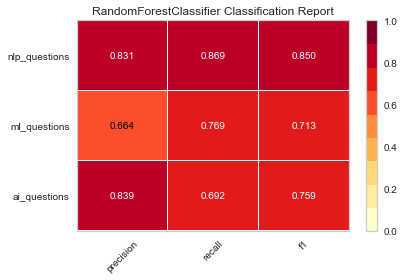

In [172]:
# Instantiate Model
tfidf_clf = RandomForestClassifier(
    n_estimators=100, max_depth=10, random_state=SET_RANDOM, n_jobs=-1
)

viz_report = ClassificationReport(tfidf_clf, classes=collections)
viz_report.fit(tfidf_vector, y_train)
viz_report.score(tfidf_test_vector, y_test)
viz_report.show()

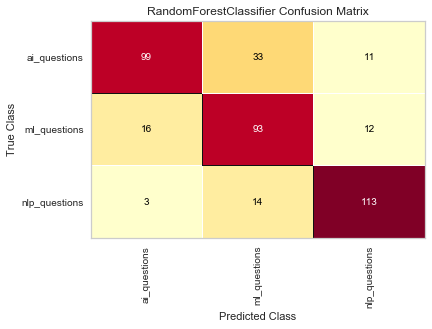

In [171]:
cm = ConfusionMatrix(tfidf_clf, classes=collections)
cm.fit(tfidf_vector, y_train)
cm.score(tfidf_test_vector, y_test)
cm.show()

# Doc2Vec
Document Embeddings will be built utilizing the gensim library.

In [182]:
# Create list of words from document
def create_gensim_tagged_doc(df: pd.DataFrame) -> list:
    tokens = [doc.split() for doc in df["cleaned_question"]]
    return tokens, [TaggedDocument(doc, [i]) for i, doc in enumerate(tokens)]

In [183]:
train_tokens, train_corp = create_gensim_tagged_doc(x_train)
test_tokens, test_corp = create_gensim_tagged_doc(x_test)

In [184]:
model_50 = Doc2Vec(
    train_corp, vector_size=50, min_count=2, epochs=50, seed=SET_RANDOM
)

In [185]:
model_50.train(
    train_corp, total_examples=model_50.corpus_count, epochs=model_50.epochs
)

In [188]:
# Train
model_50_vectors = np.zeros((len(train_tokens), 50))
for i in range(0, len(train_tokens)):
    model_50_vectors[i, ] = model_50.infer_vector(train_tokens[i]).transpose()

# Test
model_50_vectors_test = np.zeros((len(test_tokens), 50))
for i in range(0, len(test_tokens)):
    model_50_vectors_test[i, ] = model_50.infer_vector(test_tokens[i]).transpose()

In [190]:
print("Doc2Vec training shape = {}".format(model_50_vectors.shape))
print("Doc2Vec testing shape = {}".format(model_50_vectors_test.shape))

Doc2Vec training shape = (919, 50)
Doc2Vec testing shape = (394, 50)


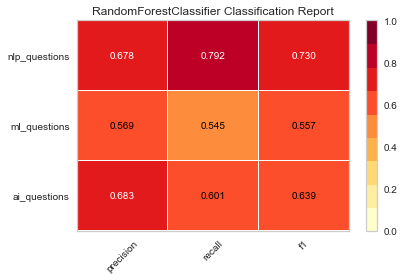

In [191]:
# Instantiate Model
d2v50_clf = RandomForestClassifier(
    n_estimators=100, max_depth=10, random_state=SET_RANDOM, n_jobs=-1
)

viz_report_d2v50 = ClassificationReport(d2v50_clf, classes=collections)
viz_report_d2v50.fit(model_50_vectors, y_train)
viz_report_d2v50.score(model_50_vectors_test, y_test)
viz_report_d2v50.show()

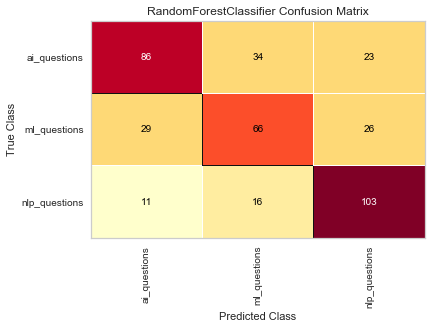

In [192]:
cm_d2v50 = ConfusionMatrix(d2v50_clf, classes=collections)
cm_d2v50.fit(model_50_vectors, y_train)
cm_d2v50.score(model_50_vectors_test, y_test)
cm_d2v50.show()